# <center>Analyse daily meassurements from HRV Logger App<center>
### <center>Databasis: feature computation from hrv logger app<center>

In [57]:
import pandas as pd
from csv_prepare import csv_cp
from create_df import read_df
import seaborn as sns
import matplotlib.pyplot as plt

# <center> User Input <center>

In [58]:
# select which measurements to show
select_measurement = ['ot_m', 'ot_a']   #so far just 2 sets are selectable
plt_select_length = 4                   #select at which character the measurements are divided for the plot

## Obsidian related plots ##
windowframe = '7D' # select how many days to show 
select_rolling = 15 # select number of measurements for rolling median calculation

## <center> Setup Dataframes <center>

### Import data from filesystem

In [59]:
# copy files to workdir, create column measurement, format timestamp
csv_cp()

#create initial dataframe
df = read_df()

# add date column to df
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

### Setup individual dataframes

In [60]:
# dataframes per measurement
select_measurement_idx0 = df[df['measurement'].str.contains(select_measurement[0])]
select_measurement_idx0 = select_measurement_idx0.sort_values('measurement')
select_measurement_idx1 = df[df['measurement'].str.contains(select_measurement[1])]
select_measurement_idx1 = select_measurement_idx1.sort_values('measurement')

# select last measurement
idx0_lastMeasurement = df[df['measurement'].str.contains(select_measurement_idx0.sort_values('measurement')['measurement'].unique()[-1])]
idx1_lastMeasurement = df[df['measurement'].str.contains(select_measurement_idx1.sort_values('measurement')['measurement'].unique()[-1])]

# grouped dataframes, used in calculate rolling values
gpDate_select_measurement_idx0 = select_measurement_idx0.groupby('date').median()
gpDate_select_measurement_idx0['rol_rmssd'] = gpDate_select_measurement_idx0['rmssd'].rolling(select_rolling).median()
gpDate_select_measurement_idx0['rol_hr'] = gpDate_select_measurement_idx0['hr'].rolling(select_rolling).median()

gpDate_select_measurement_idx1 = select_measurement_idx1.groupby('date').median()
gpDate_select_measurement_idx1['rol_rmssd'] = gpDate_select_measurement_idx1['rmssd'].rolling(select_rolling).median()
gpDate_select_measurement_idx1['rol_hr'] = gpDate_select_measurement_idx1['hr'].rolling(select_rolling).median()

# dataframes for heatmap
corr_idx0 = pd.DataFrame(select_measurement_idx0)
corr_idx0 = corr_idx0.drop([
    'artifacts',
    'time',
    'measurement',
    'date',
    'datapoint'],axis=1)
corr_idx0.reset_index()

corr_idx1 = pd.DataFrame(select_measurement_idx1)
corr_idx1 = corr_idx1.drop([
    'artifacts',
    'time',
    'measurement',
    'date',
    'datapoint'],axis=1)
corr_idx1.reset_index()

# all measurements, long format, grouped by date, select column for plot
gp_MesDt = df.groupby(['measurement', 'date']).median()[['hr', 'rmssd']]
gp_MesDt.reset_index(drop= False, inplace= True)
gp_MesDt = gp_MesDt[gp_MesDt['measurement'].str.contains('|'.join(select_measurement))]
gp_MesDt['plt_select'] = gp_MesDt['measurement'].str[:plt_select_length]

# create filter last 7 days, group by date
plt_df_1 = pd.DataFrame(gp_MesDt[gp_MesDt['measurement'].str.contains(select_measurement[0])])
plt_df_1.set_index('date', drop= True, inplace= True)
plt_df_1 = plt_df_1.last(windowframe)
plt_df_1.reset_index(drop= False, inplace= True)
plt_df_1 = pd.merge(plt_df_1,
                    gpDate_select_measurement_idx0[['rol_hr', 'rol_rmssd']],
                    on= 'date',
                    how= 'left')

plt_df_2 = pd.DataFrame(gp_MesDt[gp_MesDt['measurement'].str.contains(select_measurement[1])])
plt_df_2.set_index('date', drop= True, inplace= True)
plt_df_2 = plt_df_2.last(windowframe)
plt_df_2.reset_index(drop= False, inplace= True)
plt_df_2 = pd.merge(plt_df_2,
                    gpDate_select_measurement_idx1[['rol_hr', 'rol_rmssd']],
                    on= 'date',
                    how= 'left')

plt_df = pd.concat([plt_df_1, plt_df_2])
plt_df.reset_index(drop=True, inplace=True)

## Check imports
name of measurement | measurement count | date last file

In [61]:
print('Morgenroutine: ', 
      select_measurement_idx0.sort_values('measurement')['measurement'].unique()[-1],
      '|', 
      len(select_measurement_idx0.sort_values('measurement')['measurement'].unique()),
      '|',
      select_measurement_idx0['time'].iloc[-1].day,'-',select_measurement_idx0['time'].iloc[-1].month,'-',select_measurement_idx0['time'].iloc[-1].year)

print('Abendroutine:  ', 
      select_measurement_idx1.sort_values('measurement')['measurement'].unique()[-1],
      '|', 
      len(select_measurement_idx1.sort_values('measurement')['measurement'].unique()),
      '|',
      select_measurement_idx1['time'].iloc[-1].day,'-',select_measurement_idx1['time'].iloc[-1].month,'-',select_measurement_idx1['time'].iloc[-1].year)

Morgenroutine:  ot_m83 | 23 | 4 - 3 - 2023
Abendroutine:   ot_a82 | 20 | 4 - 3 - 2023


## Set styling for all plots

In [62]:
sns.set_theme(style= 'whitegrid',
              palette= 'tab10',
              context= 'notebook'
              )

# <center> Explore data
<center> Focus on HR and RMSSD Measurements

## All Measurements
Check important variables in all measurements  
Per measurement point

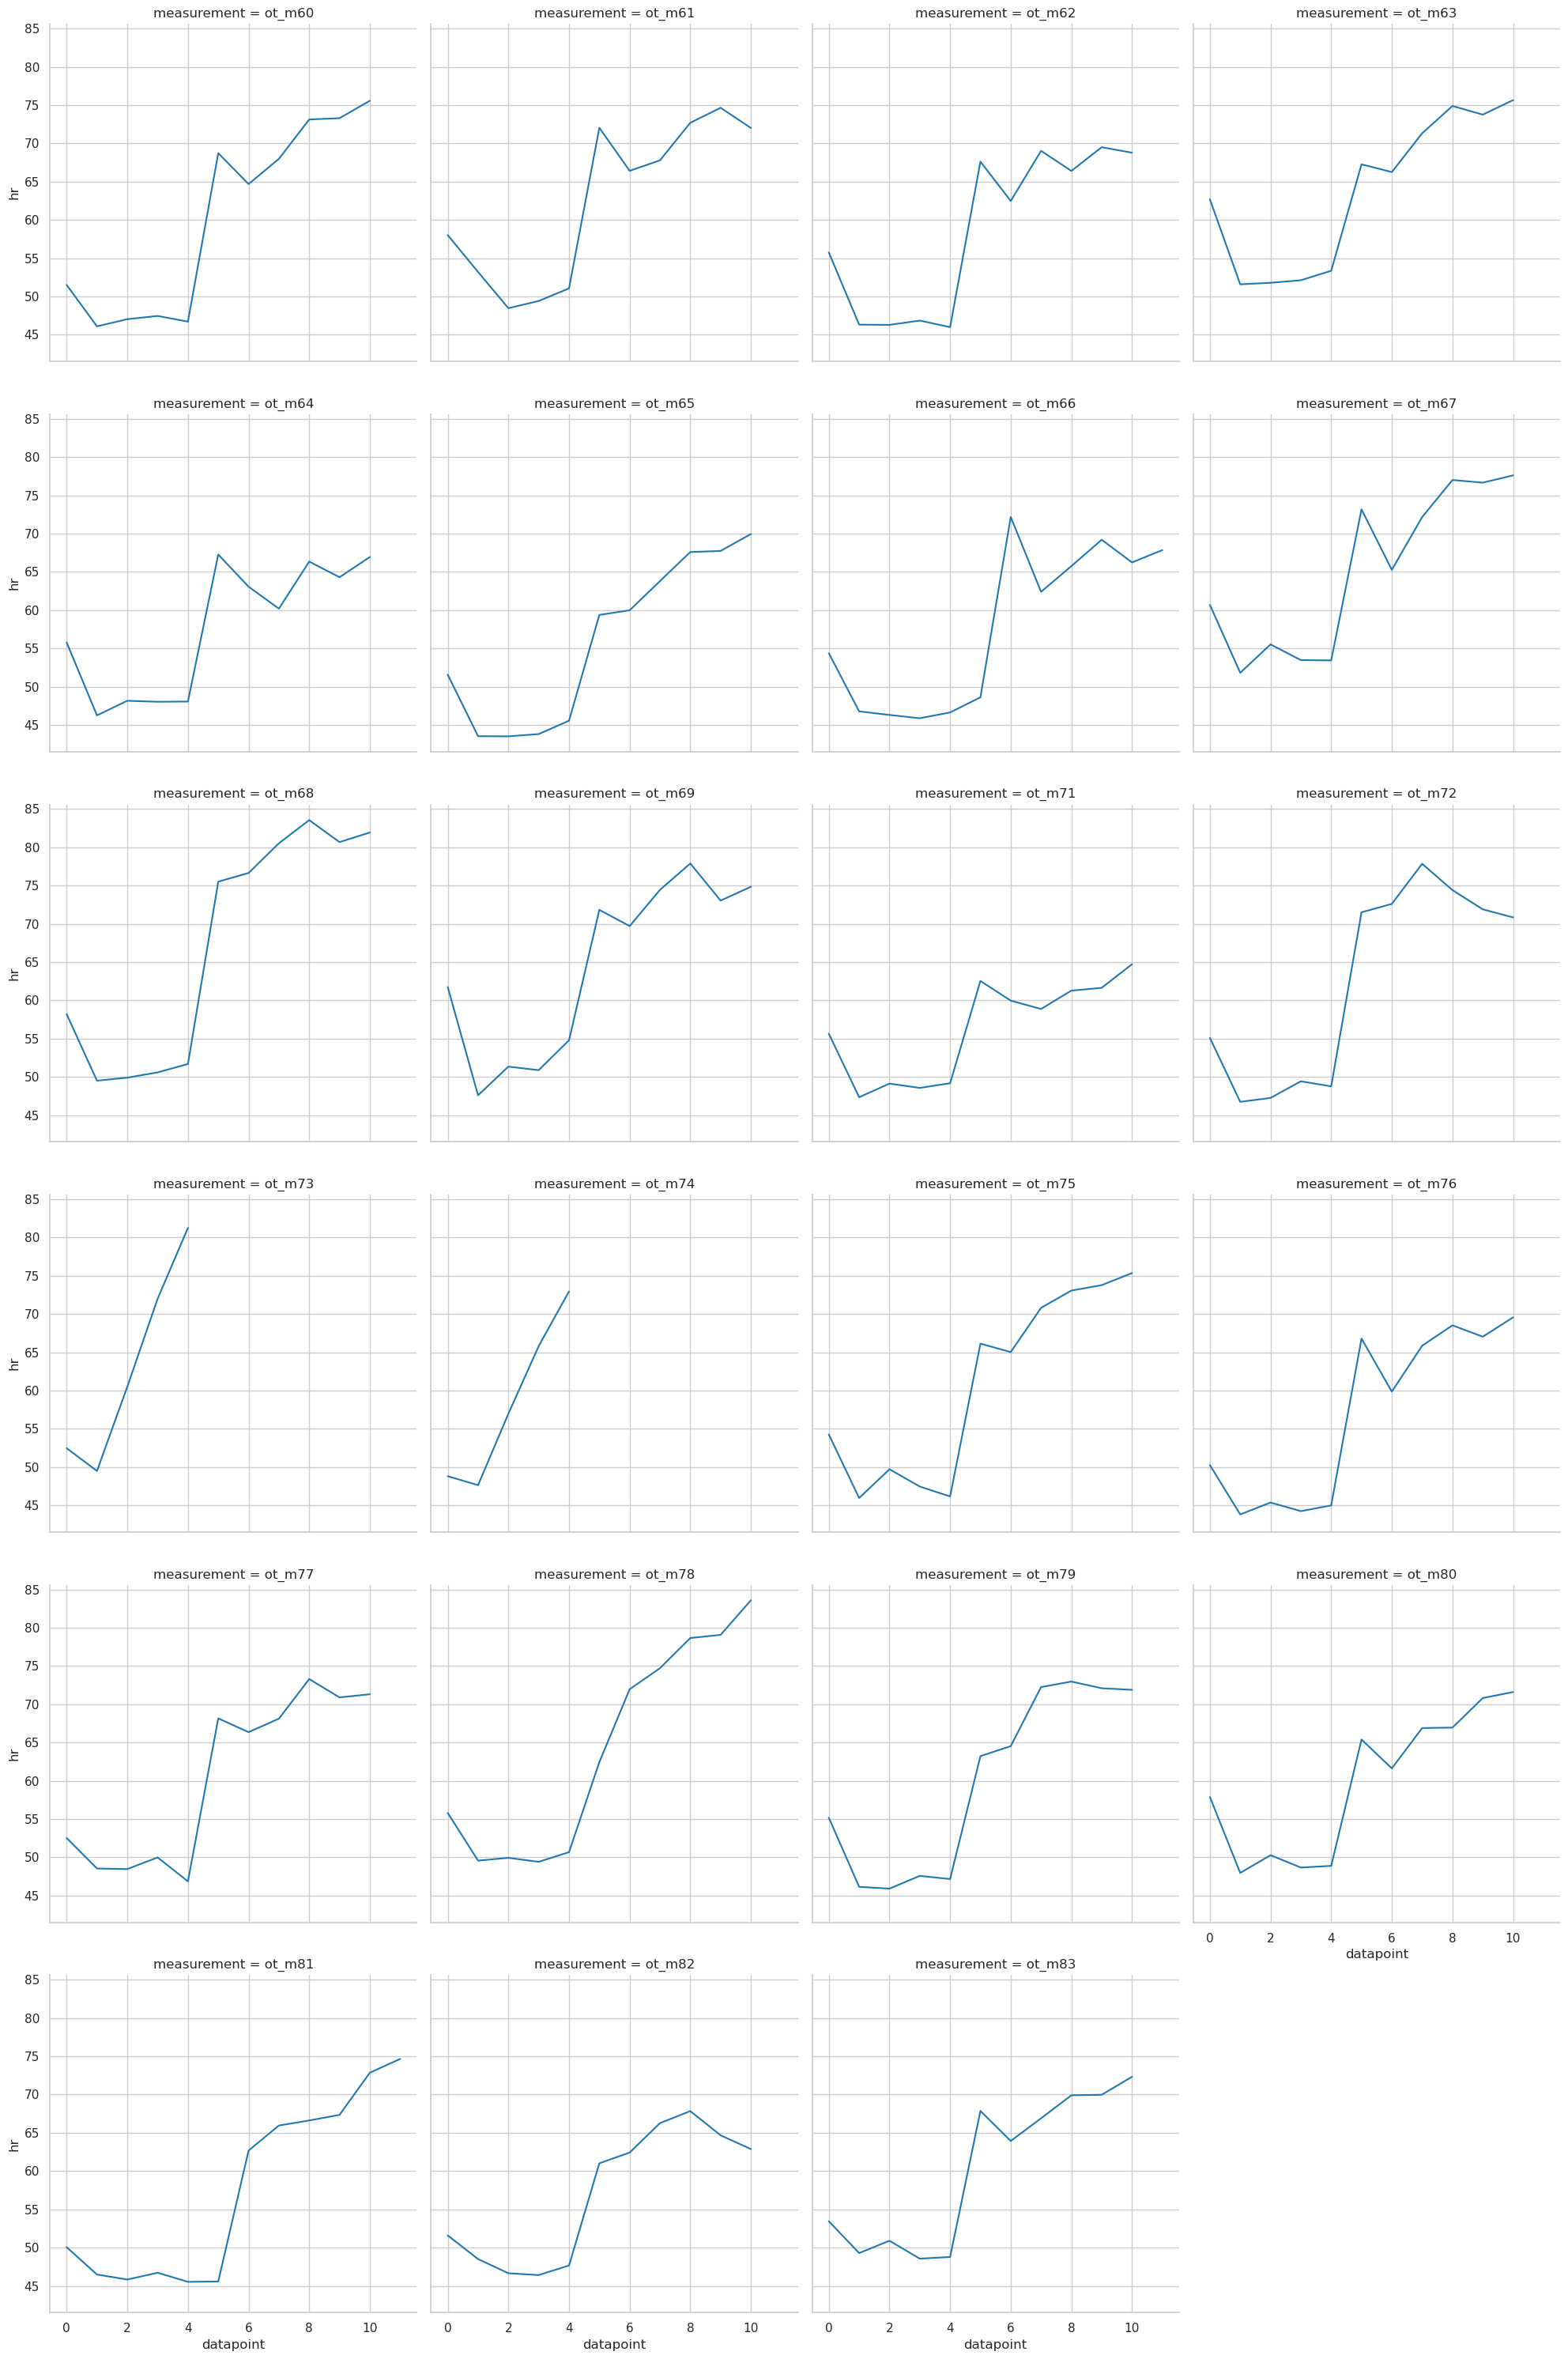

In [63]:
sns.relplot(data=select_measurement_idx0,
            x='datapoint',
            y='hr',             # choose variable to check
            col='measurement',
            col_wrap=4,
            kind='line')

## Last Measurement
Per measurement point  
See how individual measurement looks like

Text(0.5, 1.0, 'Evening Measurement')

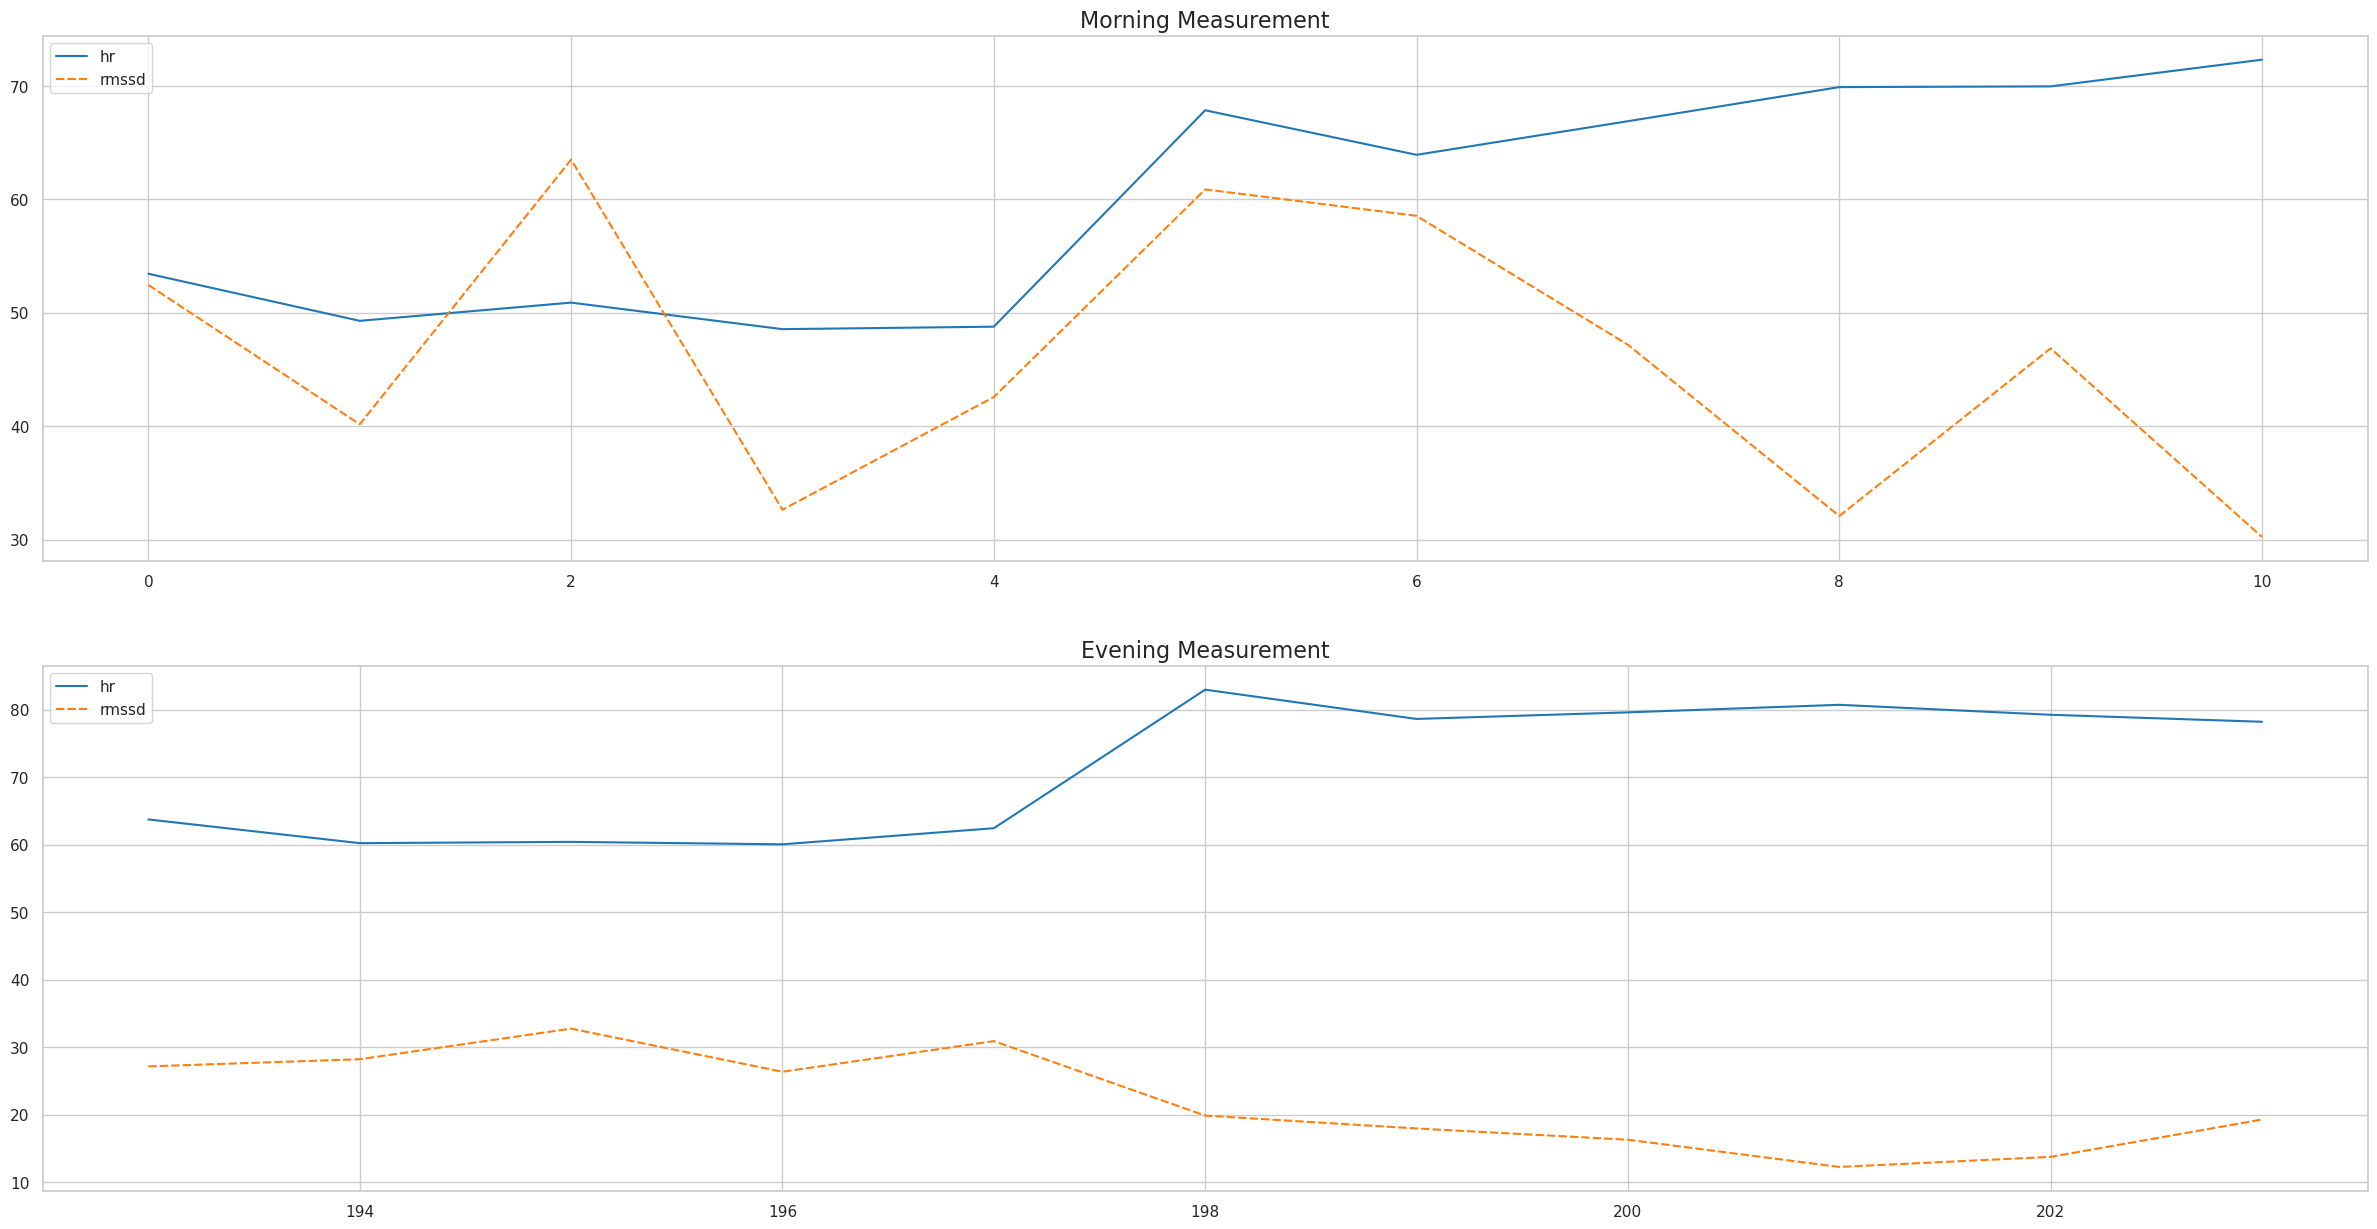

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,15) )

sns.lineplot(data=idx0_lastMeasurement[['hr', 'rmssd']],
             ax=axes[0])
sns.lineplot(data=idx1_lastMeasurement[['hr', 'rmssd']],
             ax=axes[1])
axes[0].set_title("Morning Measurement", fontsize=16)
axes[1].set_title("Evening Measurement", fontsize=16)


## All Measurements with variance
Per measurement point  
See how values are distributed at each measureing point

Text(0.5, 1.0, 'rmssd evening')

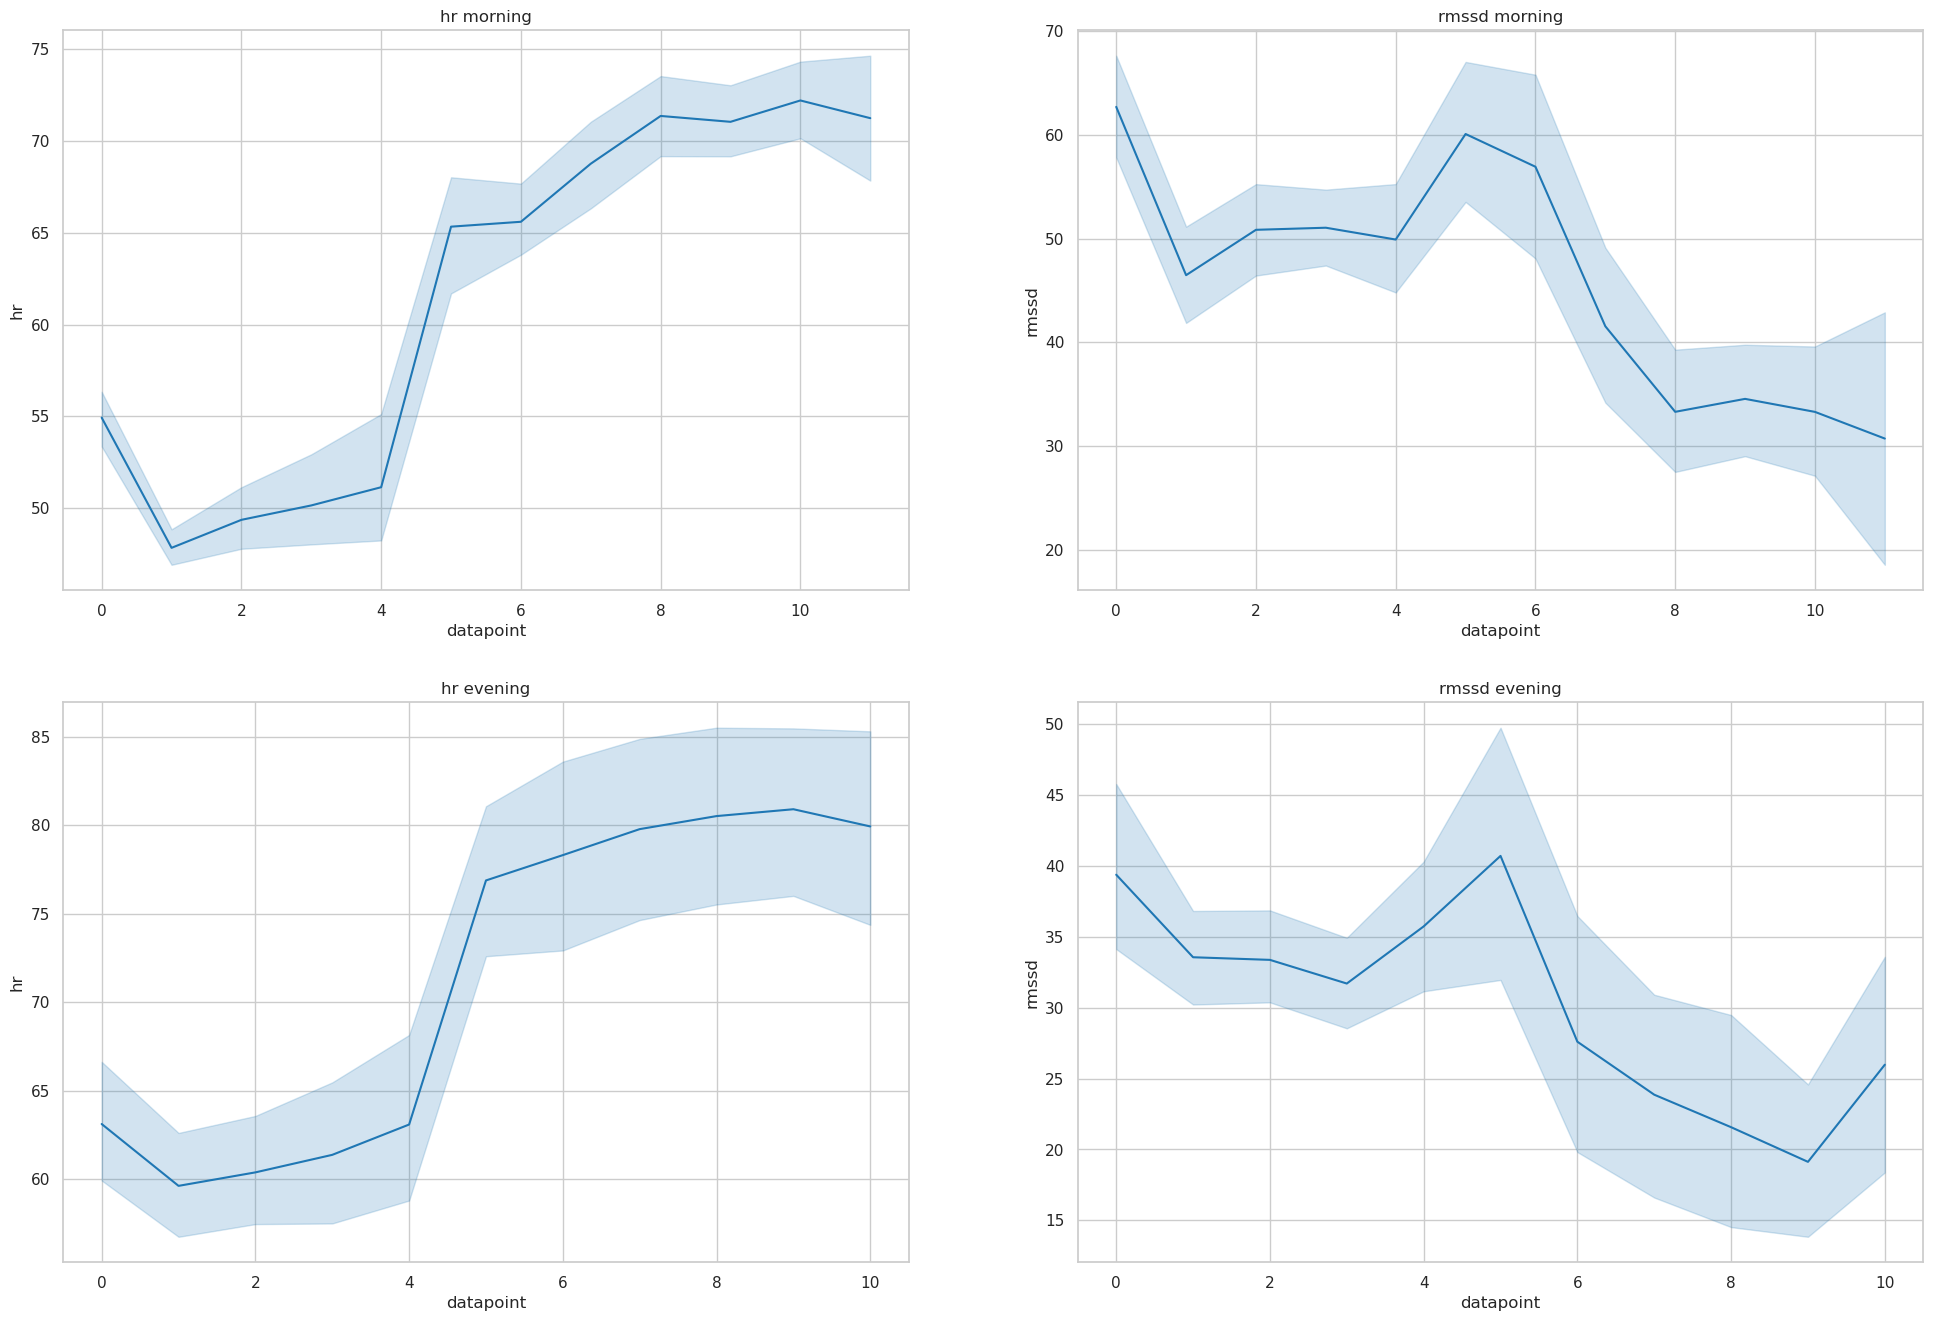

In [65]:
fig, axes = plt.subplots(2, 2, squeeze=False, figsize=(24,16) )

# morning
sns.lineplot(data=select_measurement_idx0, x='datapoint', y='hr', ax=axes[0, 0])
axes[0,0].set_title('hr morning')
sns.lineplot(data=select_measurement_idx0, x='datapoint', y='rmssd', ax=axes[0, 1])
axes[0,1].set_title('rmssd morning')

# evening
sns.lineplot(data=select_measurement_idx1, x='datapoint', y='hr', ax=axes[1, 0])
axes[1,0].set_title('hr evening')
sns.lineplot(data=select_measurement_idx1, x='datapoint', y='rmssd', ax=axes[1, 1])
axes[1,1].set_title('rmssd evening')

## Morning/evening measurements
Timeseries with variance

Text(0.5, 1.0, 'Heartrate')

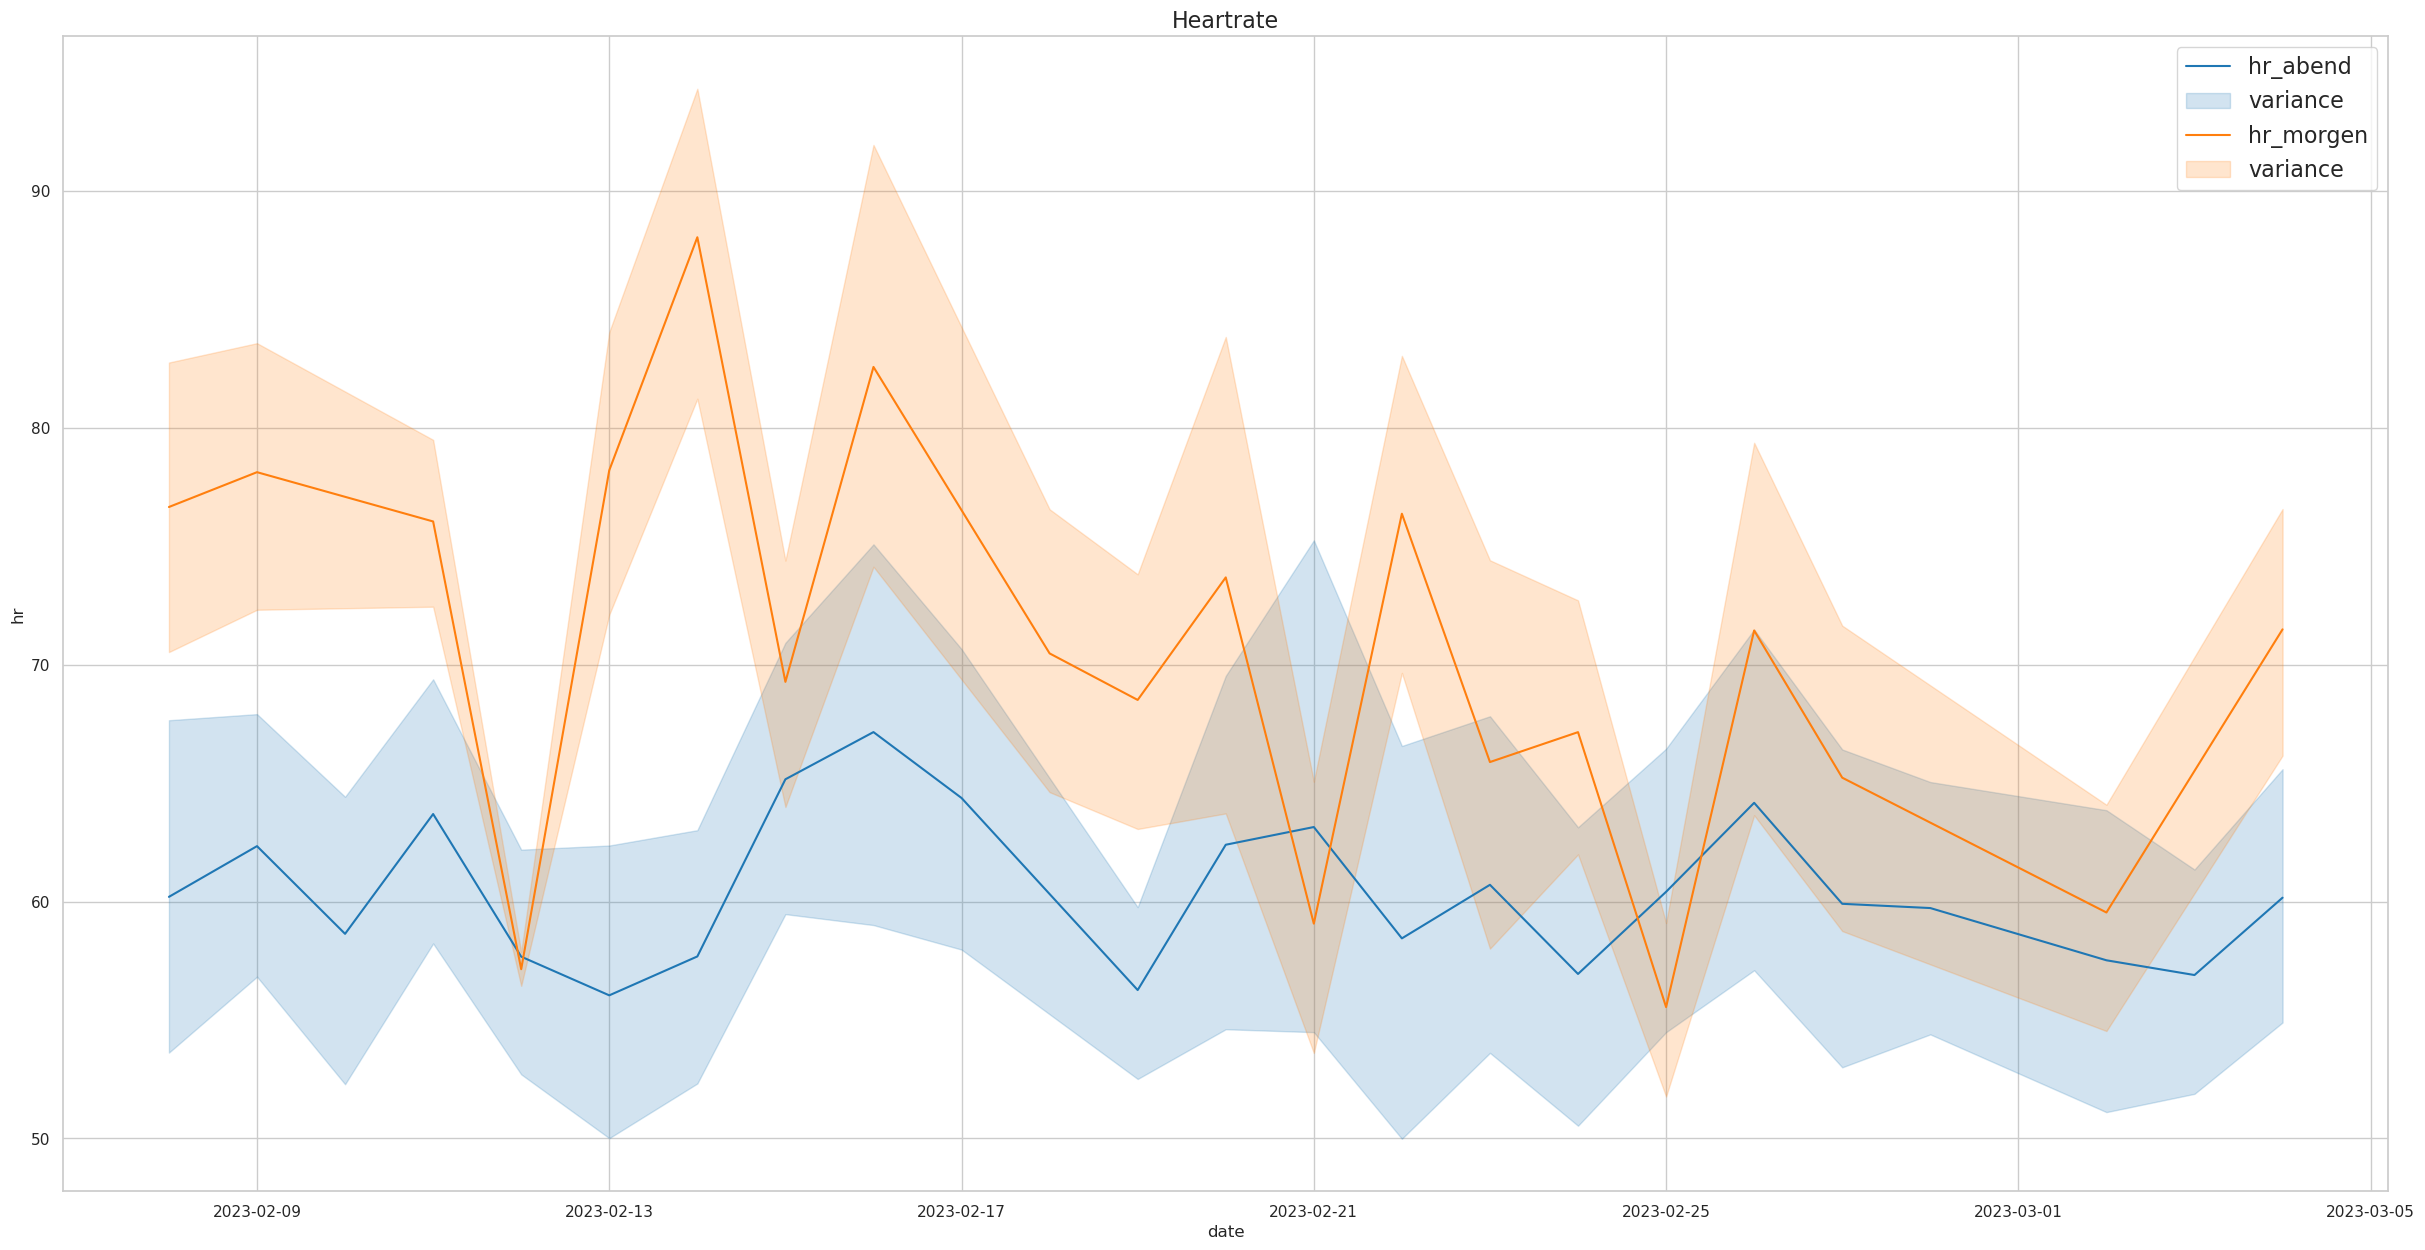

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,15) )

sns.lineplot(data=select_measurement_idx0,
             x='date',
             y='hr')
sns.lineplot(data=select_measurement_idx1,
             x='date',
             y='hr')
axes.legend(['hr_abend', 'variance', 'hr_morgen', 'variance'], fontsize=16)
axes.set_title("Heartrate", fontsize=16)

### Heatmap for all recorded data
See how individual measurements correlate

Text(0.5, 1.0, 'Evening Measurement')

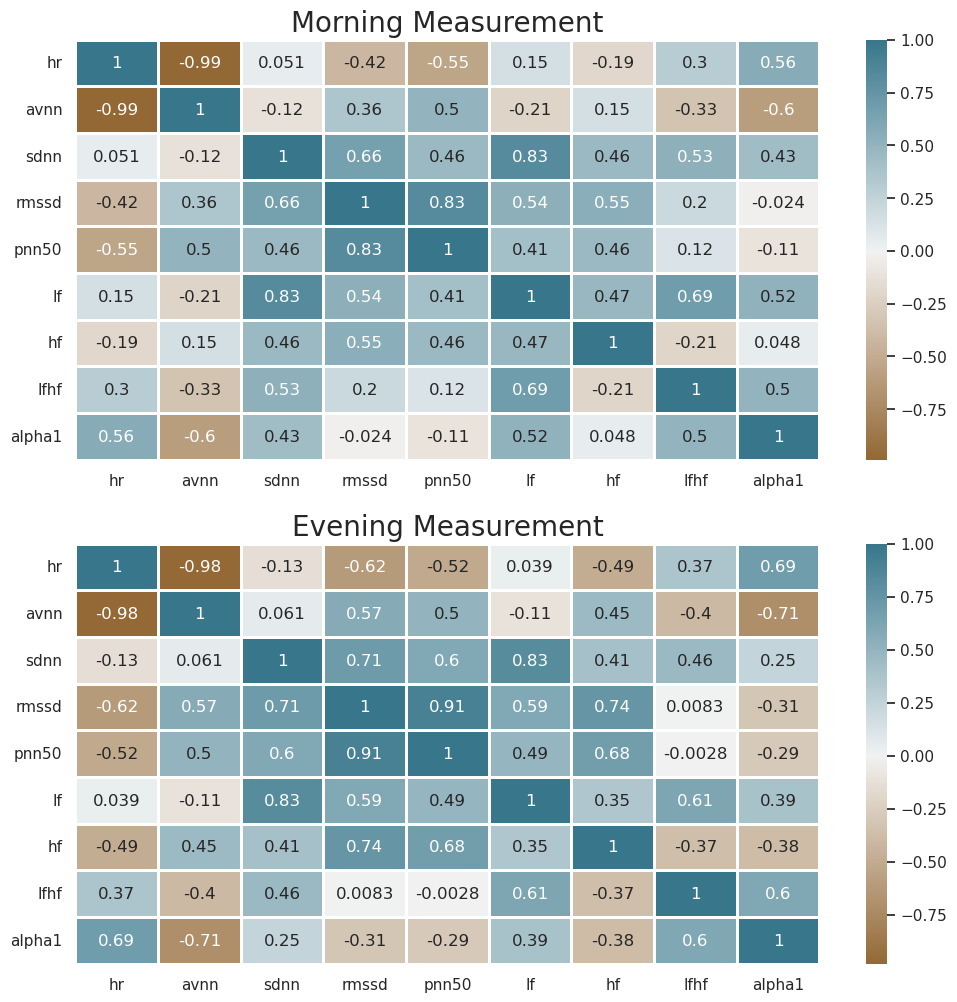

In [67]:
fig, axes = plt.subplots(nrows=2, 
                         ncols=1,
                        figsize=(12,12))

# color palette
cmap = sns.diverging_palette(47, 221, l=47, s=77, as_cmap=True)

# morning measurements
sns.heatmap(corr_idx0.corr(),
            linewidths=1,
            center=0,
            cmap=cmap, 
            annot=True,
            ax=axes[0]
            )
axes[0].set_title('Morning Measurement', fontsize=20)

# evening measurements
sns.heatmap(corr_idx1.corr(),
            linewidths=1,
            center=0,
            cmap=cmap, 
            annot=True,
            ax=axes[1]
            )
axes[1].set_title('Evening Measurement', fontsize=20)

## Kde Plots for hr/rmssd values
See how the values are distributed  

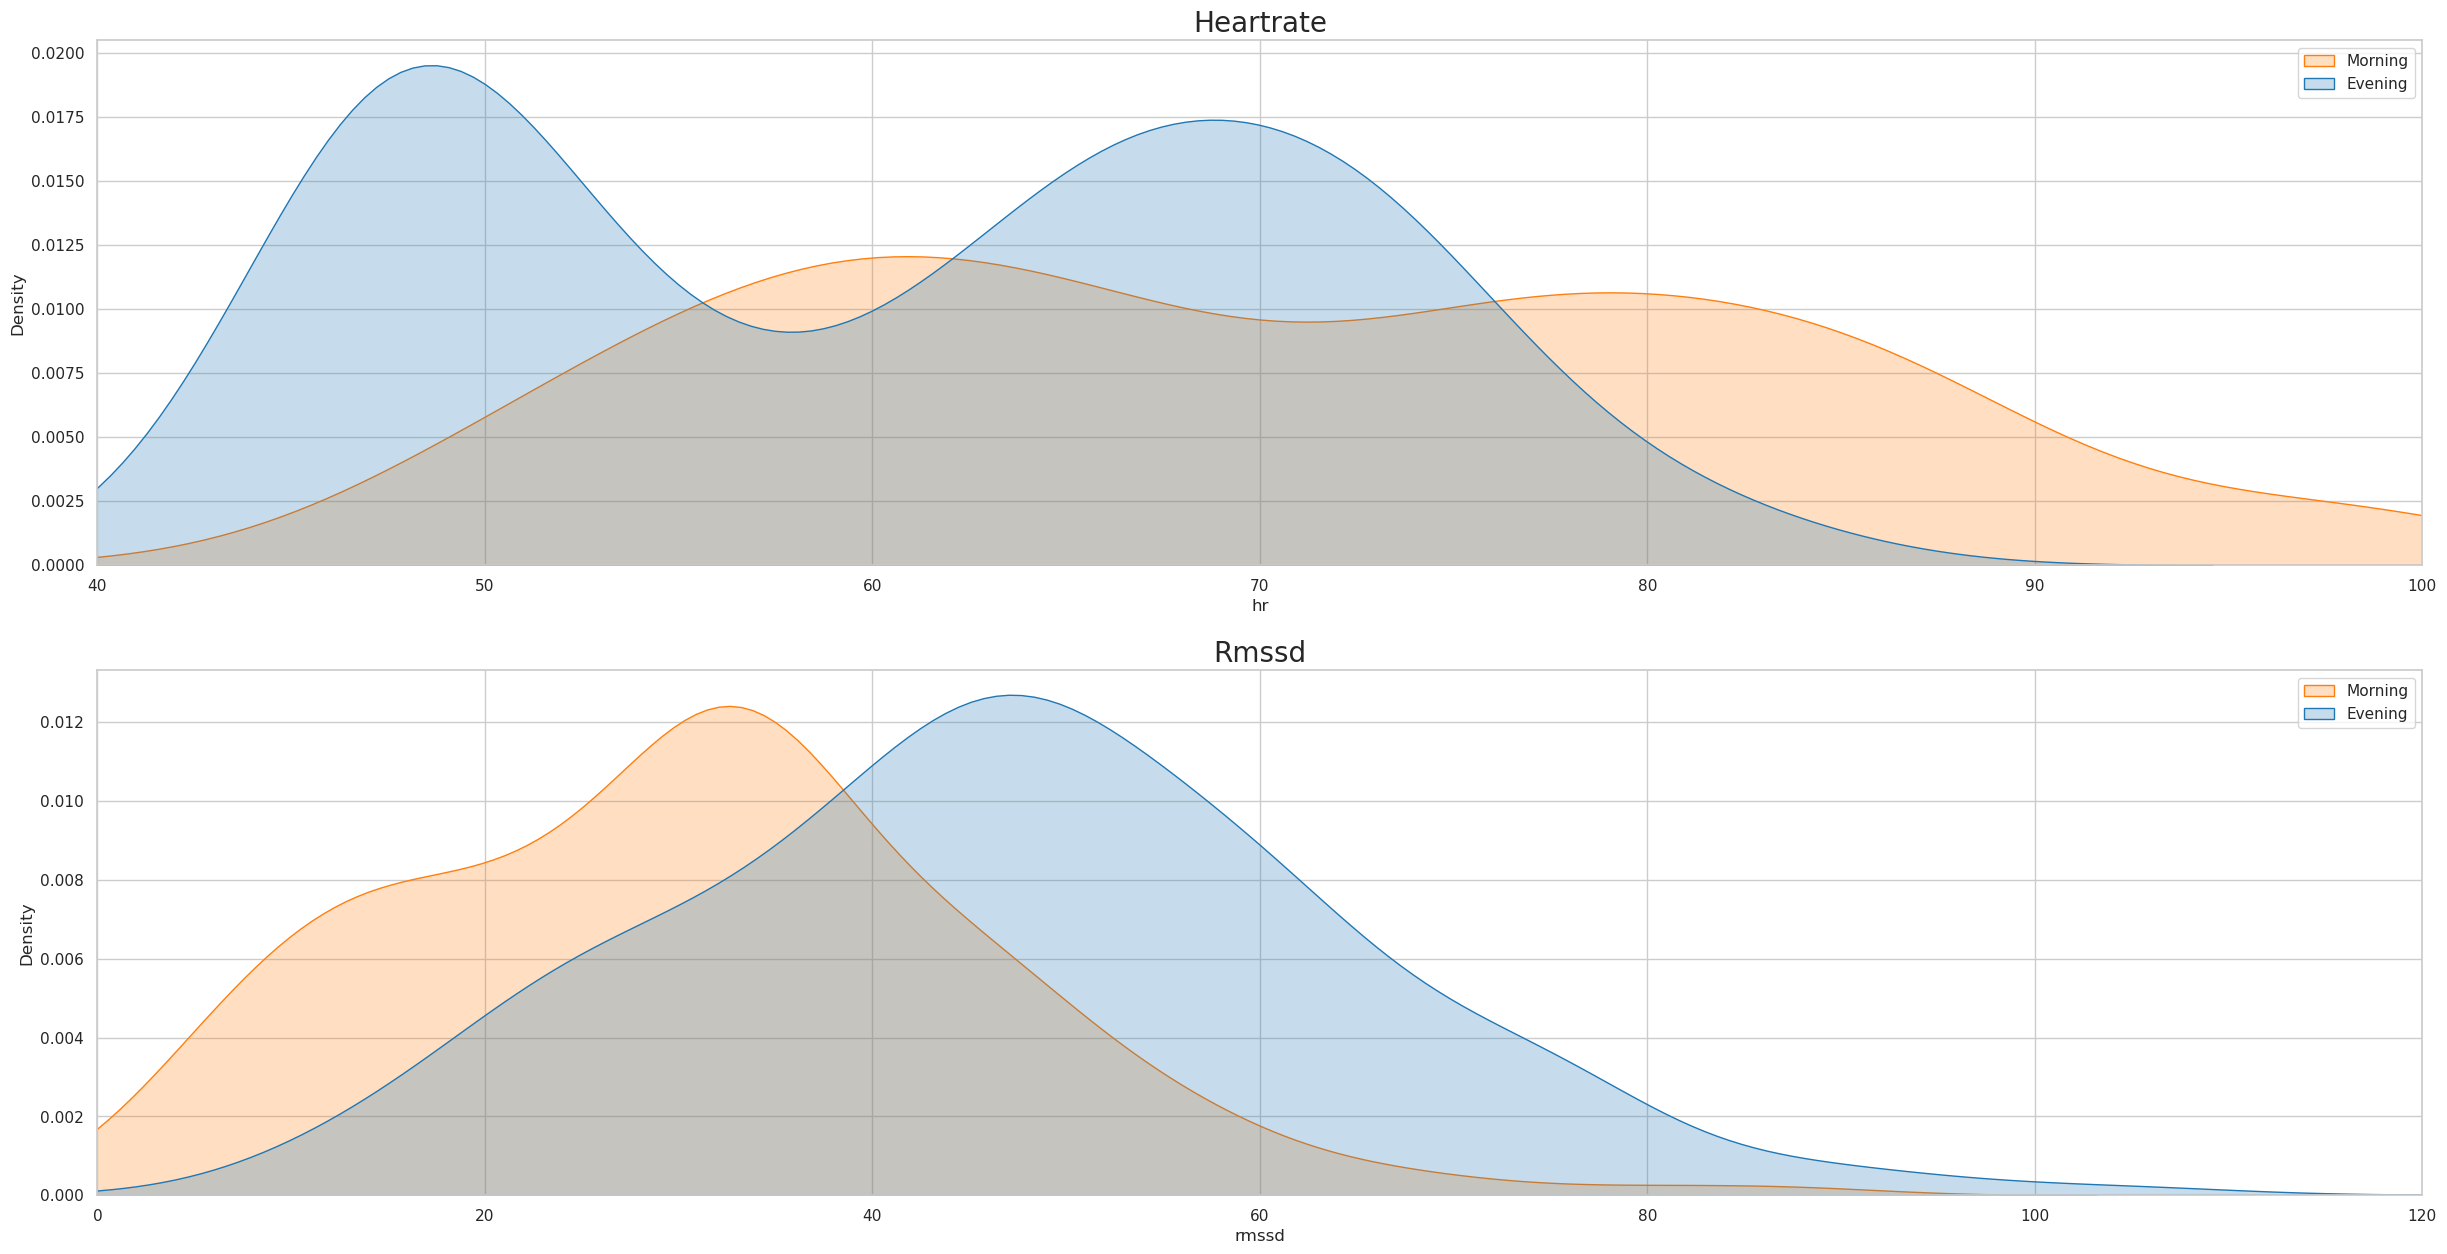

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,15))
sns.kdeplot(data=df,
            x='hr',
            hue=df['measurement'].str[:4],
            fill=True,
            ax=axes[0])
axes[0].set_title('Heartrate', fontsize=20)
axes[0].set_xlim(40, 100)
axes[0].legend(labels = ['Morning', 'Evening'])
'hr''hr'
sns.kdeplot(data=df,
            x='rmssd',
            hue=df['measurement'].str[:4],
            fill=True,
            ax=axes[1])
axes[1].set_title('Rmssd', fontsize=20)
axes[1].set_xlim(0, 120)
axes[1].legend(labels = ['Morning', 'Evening'])

## Histogram Plots
Distribution of hr/rmssd values per measurement setting

(5.0, 100.0)

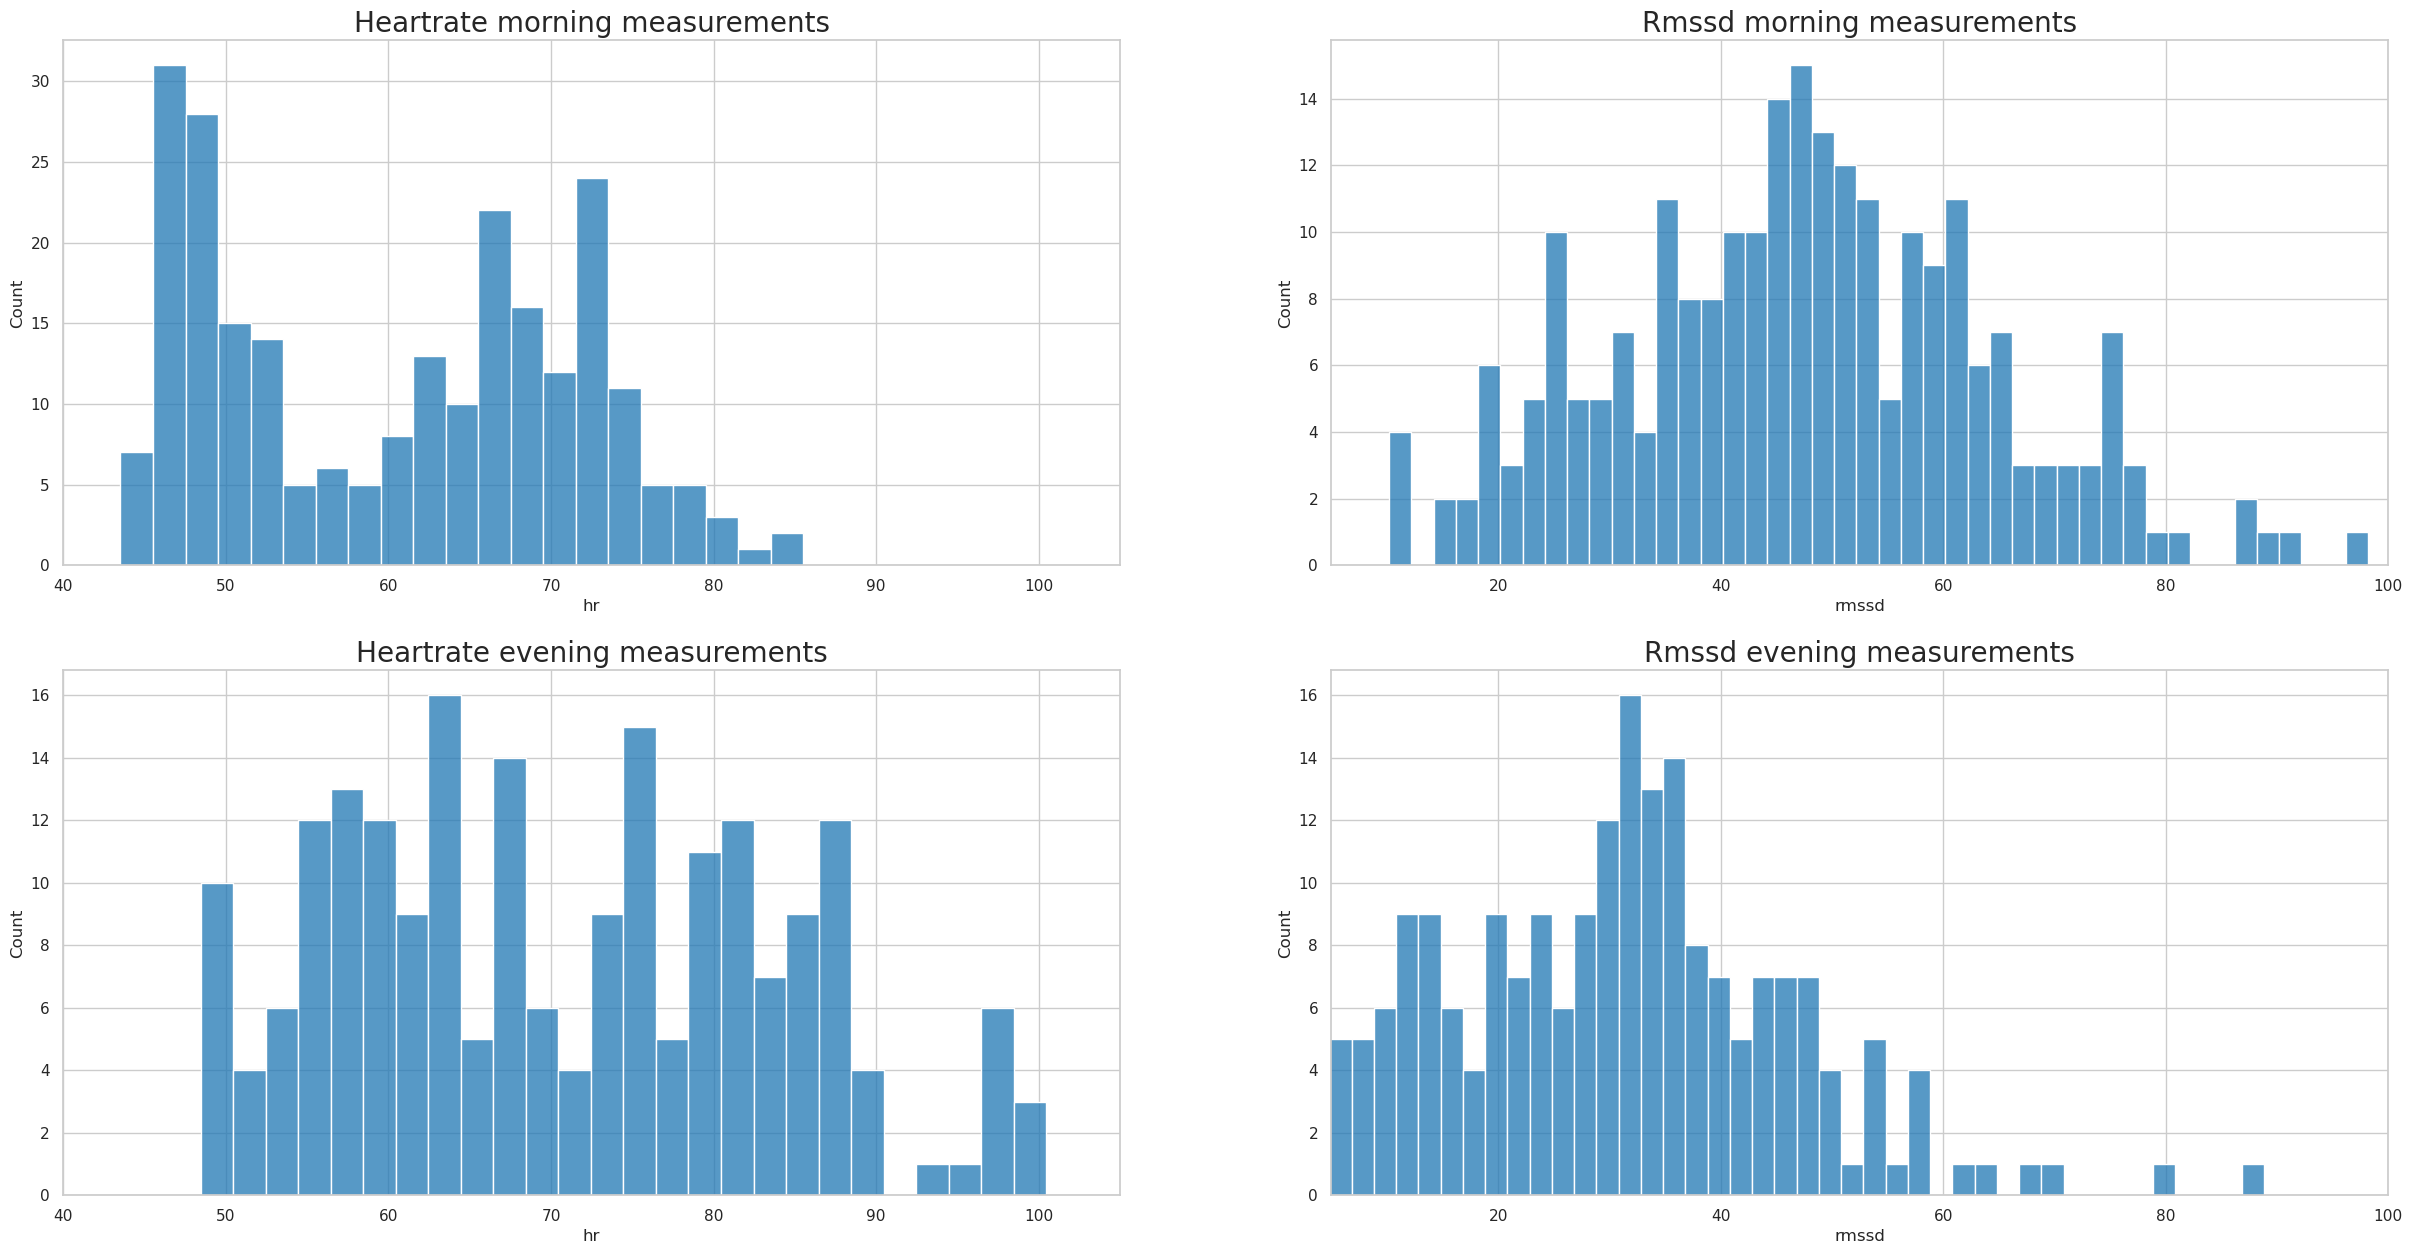

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,15))

# morning measurements
sns.histplot(data=select_measurement_idx0, 
             x='hr', 
             binwidth=2, 
             ax=axes[0, 0]
             )
axes[0, 0].set_title('Heartrate morning measurements', fontsize=20)
axes[0, 0].set_xlim(40, 105)

sns.histplot(data=select_measurement_idx0, 
             x='rmssd', 
             binwidth=2, 
             ax=axes[0, 1]
             )
axes[0, 1].set_title('Rmssd morning measurements', fontsize=20)
axes[0, 1].set_xlim(5, 100)

# evening measurements
sns.histplot(data=select_measurement_idx1, 
             x='hr', 
             binwidth=2, 
             ax=axes[1, 0]
             )
axes[1, 0].set_title('Heartrate evening measurements', fontsize=20)
axes[1, 0].set_xlim(40, 105)

sns.histplot(data=select_measurement_idx1, 
             x='rmssd', 
             binwidth=2, 
             ax=axes[1, 1]
             )
axes[1, 1].set_title('Rmssd evening measurements', fontsize=20)
axes[1, 1].set_xlim(5, 100)

# Output for obsidian myHealth
Generate image file for Obsidian myHealth input

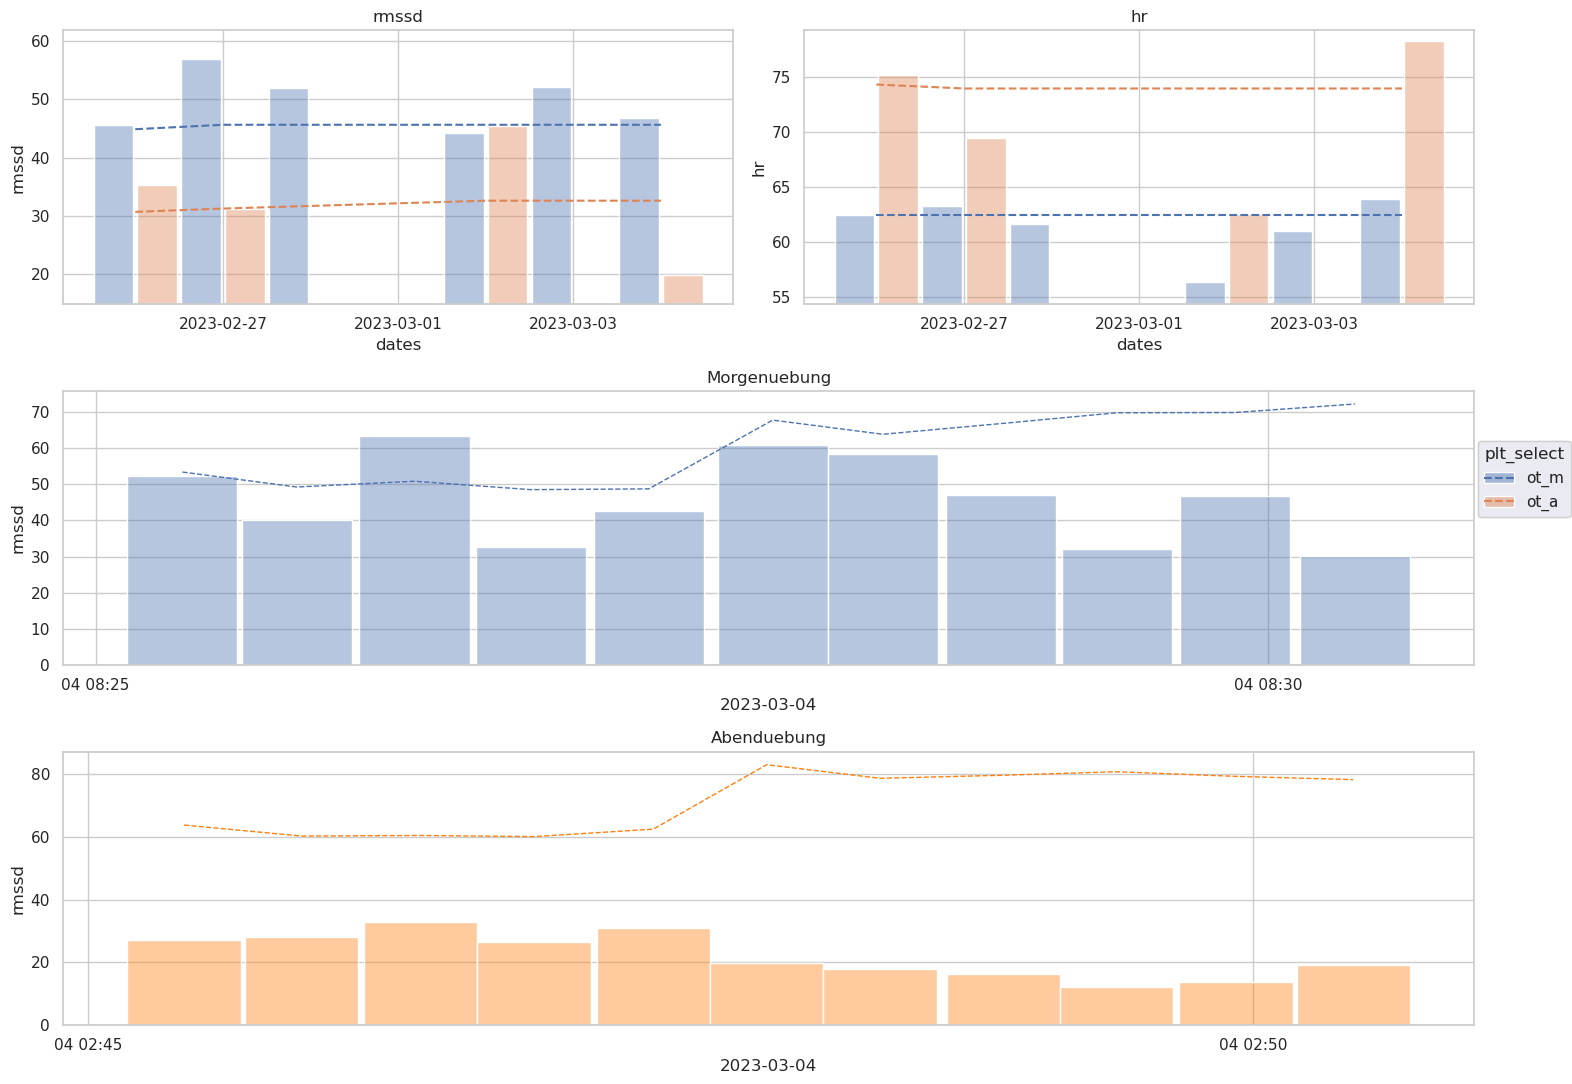

In [70]:
import seaborn.objects as so

plt.close('all')
fig = plt.figure(figsize=(15,11))

# define grid and plot windows in main grid
sf1 = plt.subplot2grid((3,2), (0,0))    #links oben
sf2 = plt.subplot2grid((3,2), (0,1))    #rechts oben
sf3 = plt.subplot2grid((3,2), (1,0), colspan=2)
sf4 = plt.subplot2grid((3,2), (2,0), colspan=2)

# create plots with seaborn object interface
(
    so.Plot(plt_df,
            y='rmssd',
            x='date',
            color= 'plt_select')
    .add(so.Bars(alpha= 0.4), 
         so.Agg('median'), 
         so.Dodge(gap=.1))  # type: ignore
    .add(so.Line(linestyle= '--'), y= 'rol_rmssd')
    .label(title= 'rmssd',
           x= 'dates')
    .limit(y= (plt_df['rmssd'].min()-5, plt_df['rmssd'].max()+5))          
    .on(sf1)
    .plot()
)

(
    so.Plot(plt_df,
            y='hr',
            x='date',
            color= 'plt_select')
    .add(so.Bars(alpha= 0.4),
         so.Agg('median'), 
         so.Dodge(gap=.1))  # type: ignore
    .add(so.Line(linestyle= '--'), y= 'rol_hr')
    .label(title= 'hr',
           x= 'dates')
    .limit(y= (plt_df['hr'].min()-2, plt_df['hr'].max()+1))
    .on(sf2)
    .plot()
)

(
    so.Plot(select_measurement_idx0[select_measurement_idx0['date'] == max(select_measurement_idx0['date'])],
            y='rmssd',
            x='time',)
    .add(so.Bars(alpha= 0.4), 
         so.Agg('median'))
    .add(so.Line(linestyle= '--', linewidth= 1,), y= 'hr')
    .label(title= 'Morgenuebung',
           x= max(select_measurement_idx0['date']).date())
    .on(sf3)
    .plot()
)

(
    so.Plot(select_measurement_idx1[select_measurement_idx1['date'] == max(select_measurement_idx1['date'])],
            y='rmssd',
            x='time',)
    .add(so.Bars(alpha= 0.4, color= '#ff7f0e'), 
         so.Agg('median'))
    .add(so.Line(linestyle= '--', linewidth= 1, color= '#ff7f0e'), y= 'hr')
    .label(title= 'Abenduebung',
           x= max(select_measurement_idx1['date']).date())
    .on(sf4)
    .plot()
)
plt.tight_layout()